In [1]:
import ROOT, os, sys, glob
import numpy as np
import math
from matplotlib import pyplot as plt
from ROOT import kBlack, kBlue, kRed
from array import array

ROOT.EnableImplicitMT(4); 

Welcome to JupyROOT 6.28/00


In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.1.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M3p5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M40_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M4_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1

In [3]:
def Efficiency_plotter(file_name):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()
    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second]));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second]));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
####################################################################################################################################################################    
    
    def indexSelect(rdf):
        rdf = rdf.Define("TkDiMu_indMatch","(TkDiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"IdxDiMu_indices", f"TkDiMu_indices[TkDiMu_indMatch]")
        rdf = rdf.Filter(f"Sum(TkDiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_mass[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_charge[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_dz[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkMu_minPT[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSum",f"TkDiMu_hwIsoSum[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSumAp",f"TkDiMu_hwIsoSumAp[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwQual",f"TkDiMu_hwQual[TkDiMu_indMatch]")
        rdf = rdf.Define("TkDiMu_IdxEta","TkDiMu_eta[TkDiMu_indMatch]")
        return rdf;

    rdf_idxSel = indexSelect(rdf_genDiMu)
    
    entries_idx_pair = rdf_idxSel.Count().GetValue()
    
####################################################################################################################################################################
    
    hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")

    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2.)&&({name}DiMu_eta <= 2)")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    rdf_selFeat = select_ind("Gen",rdf_idxSel)
    rdf_Tk_selFeat = select_ind("Tk", rdf_selFeat)
    def select_idx_tk(rdf):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"TkDiMu_Idx_good", f"(TkDiMu_IdxCharge <0.1 && TkDiMu_IdxCharge > -0.1) &&(TkDiMu_Idxdz <1 && (TkDiMu_Idxdz > -1))&&(TkDiMu_IdxMinPt > 2.) && (TkDiMu_IdxhwQual>75) && (TkDiMu_IdxEta <=2) ")                    
        rdf = rdf.Define(f"TkDiMu_sel_Idx_indices", f"IdxDiMu_indices[TkDiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum(TkDiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_IdxSel",f"TkDiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxselMass",f"TkDiMu_IdxMass[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselCharge",f"TkDiMu_IdxCharge[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_Idxseldz",f"TkDiMu_Idxdz[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselMinPt",f"TkDiMu_IdxMinPt[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwQual",f"TkDiMu_IdxhwQual[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSum",f"TkDiMu_IdxhwIsoSum[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSumAp",f"TkDiMu_IdxhwIsoSumAp[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"GoodTkDiMu_minIdx",f"TkDiMu_minIdx[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselEta",f"TkDiMu_IdxEta[TkDiMu_Idx_good]")

        return rdf;
    
    rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)
    
    entries_selIdx_pair = rdf_Tk_IdxselFeat.Count().GetValue()
    
####################################################################################################################################################################    
    hGoodIdxTkPairMass = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxselMass")
    
    h1 = hGoodIdxTkPairMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = hIdxTkPairMass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return [h1,h2,h3,e1,e2];
#     c, pad1, pad2 = createCanvasPads()
#     pad1.cd()
#     h1.Draw()
#     h2.Draw("same")
#     # to avoid clipping the bottom zero, redraw a small axis
#     h1.GetYaxis().SetLabelSize(0.0)
#     axis =ROOT.TGaxis(-5, 20, -5, 220, 20, 220, 510, "")|
#     axis.SetLabelFont(43)
#     axis.SetLabelSize(15)
#     axis.Draw()
#     pad2.cd()
#     h3.Draw("ep")
#     c.Draw()

    

In [4]:
[h1,h2,h3,e1,e2] = Efficiency_plotter("l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root")
print(e1)
print(e2)

0.5922741989505415
0.7404047452896022


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [5]:
#rdf_25.Describe()
#h3 = h3.GetPtr()

In [6]:
def createCanvasPads():
        c = ROOT.TCanvas("c", "canvas", 800, 800)
        # Upper histogram plot is pad1
        pad1 =ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
        pad1.SetBottomMargin(0)  # joins upper and lower plot
        pad1.SetGridx()
        pad1.Draw()
        # Lower ratio plot is pad2
        c.cd()  # returns to main canvas before defining pad2
        pad2 =ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
        pad2.SetTopMargin(0)  # joins upper and lower plot
        pad2.SetBottomMargin(0.2)
        pad2.SetGridx()

        pad2.Draw()

        return c, pad1, pad2;

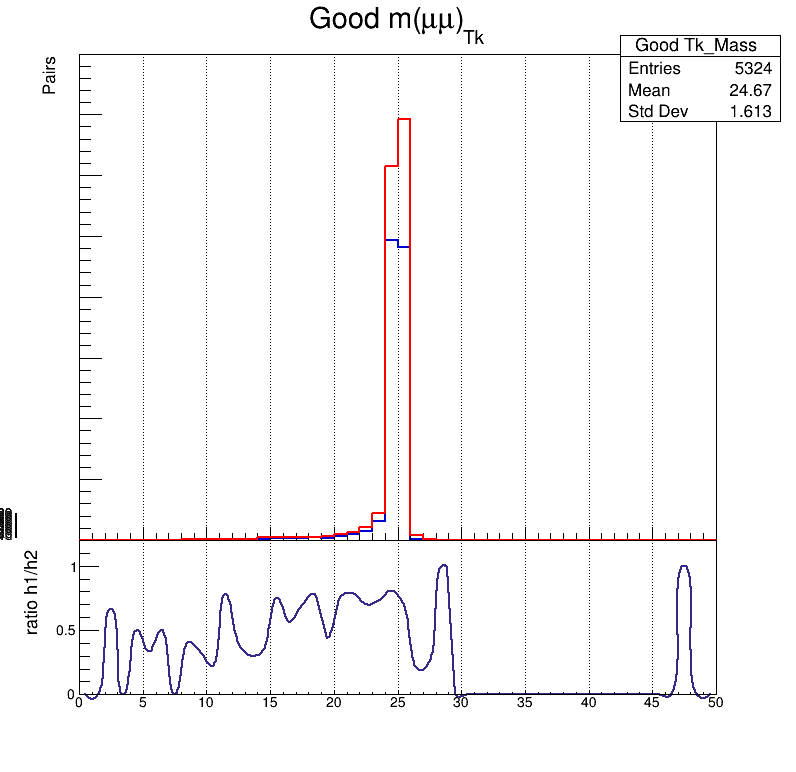

In [7]:
# c = ROOT.TCanvas()
# c.cd()
# h3.Draw("hist c plc")
# c.Draw()
c, pad1, pad2 = createCanvasPads()
pad1.cd()
h1.Draw()
h2.Draw("same")
# to avoid clipping the bottom zero, redraw a small axis
h1.GetYaxis().SetLabelSize(0.0)
axis =ROOT.TGaxis(-5, 20, -5, 220, 20, 220, 510, "")
axis.SetLabelFont(43)
axis.SetLabelSize(15)
axis.Draw()
pad2.cd()
h3.Draw("hist c plc")
c.Draw()

In [8]:
filename_list = ["l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root","l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.1.root","l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.1.root"]

(0, 'l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root')
(1, 'l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.1.root')
(2, 'l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.1.root')


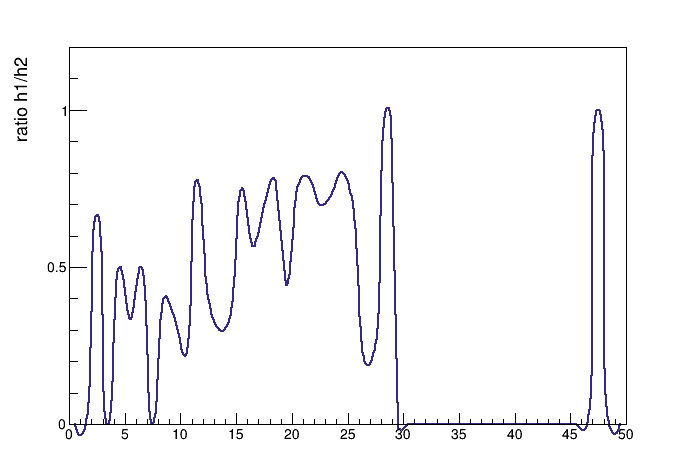

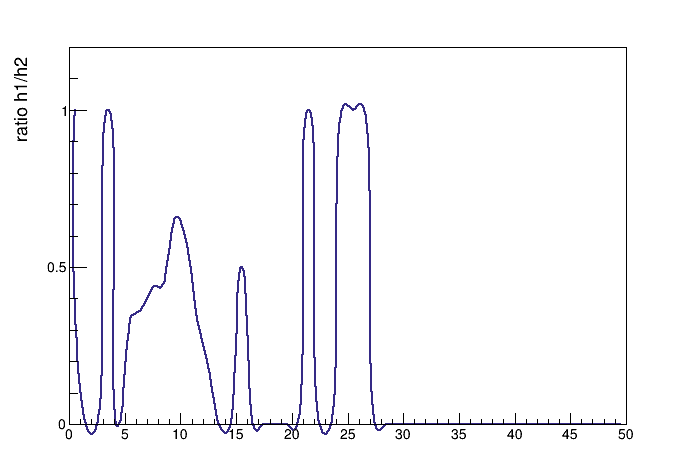

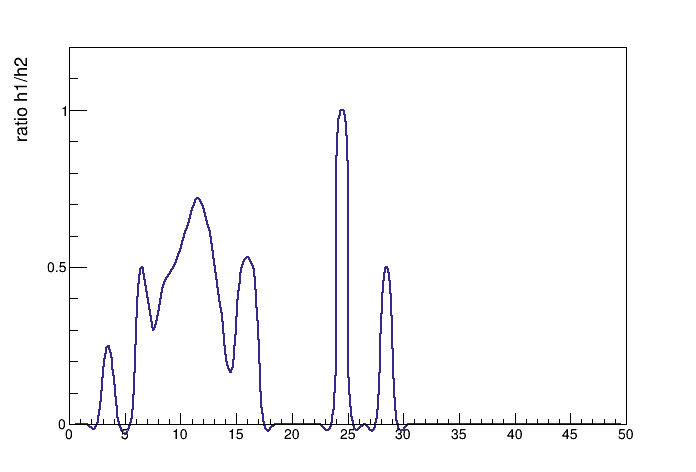

In [11]:
h1 = {}
h2 = {}
h3 = {}

for filename in enumerate(filename_list):
    print(filename)
    fname = filename[1]
    [h1[fname],h2[fname],h3[fname],e1,e2] = Efficiency_plotter(fname)
    c = ROOT.TCanvas()
    c.cd()
    h3[fname].Draw("hist c plc")
    c.Draw()